In [ ]:
import collections
import math
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import myd2l

In [2]:
import torch
import torch.nn as nn

# 定义一个嵌入层，嵌入矩阵的大小为（词汇量, 嵌入维度）
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3)

# 输入一个包含索引的张量
input_indices = torch.tensor([1, 2, 3])
output = embedding(input_indices)
print(output)

tensor([[-0.2816,  0.2148, -1.6393],
        [-1.3997,  0.0496, -0.3138],
        [-1.0370, -0.5501,  1.5659]], grad_fn=<EmbeddingBackward0>)


In [ ]:
class Seq2SeqEncoder(myd2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
    
    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state

encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
print(output.shape)
print(state.shape)

torch.Size([7, 4, 16])
torch.Size([2, 4, 16])


In [ ]:
class Seq2SeqDecoder(myd2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), dim=2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)

        return output, state

decoder = Seq2SeqDecoder(vocab_size=10, embed_size=9, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
print(output.shape)
print(state.shape)

torch.Size([4, 7, 10])
torch.Size([2, 4, 16])


In [5]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    
    return X

X = torch.Tensor([[1, 2, 3], [4, 5, 6]])
print(sequence_mask(X, torch.tensor([1, 2])))

X = torch.ones(2, 3, 4)
print(sequence_mask(X, torch.tensor([1, 2]), value=-1))

tensor([[1., 0., 0.],
        [4., 5., 0.]])
tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])


In [6]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        
        return weighted_loss

loss = MaskedSoftmaxCELoss()
print(loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0])))

tensor([2.3026, 1.1513, 0.0000])


epoch 1, loss 1.9106
epoch 10, loss 0.9302
epoch 20, loss 0.6796
epoch 30, loss 0.5305
epoch 40, loss 0.4420
epoch 50, loss 0.3740
epoch 60, loss 0.3214
epoch 70, loss 0.2830
epoch 80, loss 0.2511
epoch 90, loss 0.2160
epoch 100, loss 0.1936
epoch 110, loss 0.1705
epoch 120, loss 0.1554
epoch 130, loss 0.1445
epoch 140, loss 0.1271
epoch 150, loss 0.1212
epoch 160, loss 0.1123
epoch 170, loss 0.1111
epoch 180, loss 0.1047
epoch 190, loss 0.1014
epoch 200, loss 0.0977
epoch 210, loss 0.0921
epoch 220, loss 0.0909
epoch 230, loss 0.0909
epoch 240, loss 0.0887
epoch 250, loss 0.0854
epoch 260, loss 0.0874
epoch 270, loss 0.0881
epoch 280, loss 0.0863
epoch 290, loss 0.0838
epoch 300, loss 0.0830


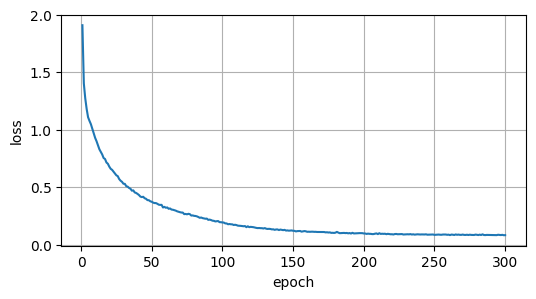

loss 0.0830, 33041.4 tokens/sec on cuda


In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    losses = []
    start_time, tokens_sum = time.time(), 0
    for epoch in range(num_epochs):
        loss_sum = 0.0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<boss>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat((bos, Y[:, : -1]), dim=1) # 这样处理后，dec_input就可以和target在时间步上一一对应
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            loss_sum += l.mean().item()
            tokens_sum += X_valid_len.sum()
            myd2l.grad_clipping(net, 1)
            optimizer.step()
        
        losses.append(loss_sum / len(data_iter))
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print(f'epoch {epoch + 1:d}, loss {losses[-1]:.4f}')
    
    time_sum = time.time() - start_time
        
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.plot(range(1, num_epochs + 1), losses)
    plt.show()

    print(f'loss {losses[-1]:.4f}, {tokens_sum / time_sum:.1f} tokens/sec on {str(device)}')

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, torch.device('cuda')

train_iter, src_vocab, tgt_vocab = myd2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = myd2l.EncoderDecoder(encoder, decoder)

train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = myd2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()

        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [13]:
def bleu(pred_seq, label_seq, k):
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))

    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_pred - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    
    return score

In [14]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai froid ., bleu 0.000
he's calm . => il est malade ., bleu 0.658
i'm home . => je suis chez moi retard recul ., bleu 0.711
